In [1]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [2]:
if os.path.exists('Raw Prepared Data.xlsx'):

    # Load the data
    price_data = pd.ExcelFile('Raw Prepared Data.xlsx')

else:

    print("Error grabbing the data")

In [3]:
allsheets = price_data.sheet_names
print(allsheets)

['EV', 'Market Cap', 'ROE', 'ROIC', 'ROA', 'Sales Growth', 'Profit Margin', 'Gross Margin', 'Quick Ratio', 'Debt to Equity', 'Capex as % of Rev', 'Asset Turnover', 'Sales', 'EBITDA', 'Equity', 'Cash and Cash Equiv', 'Free Cash Flow', 'Capex', 'RD Expenses', 'SGA Expenses', 'Net Income', 'Total Liabilities', 'Total Assets', 'Total Debt', 'Information']


In [4]:
# Loop through each sheet name
for sheet in allsheets:
    print(f"Processing sheet: {sheet}")
    df = pd.read_excel(price_data, sheet_name=sheet, index_col=0)
    
    # Do your processing here, for example:
    print(df.head(5))  # Show first 5 rows
    
    # You can add any custom logic here to adjust or analyze each sheet

Processing sheet: EV
          Feature       1998        1999        2000        2001       2002  \
ID                                                                            
000007-CN      EV  158.63606   183.94010   277.88492   202.93546  188.94495   
000011-CN      EV  577.15040   539.03290   833.49040   622.90530  332.92245   
000012-CN      EV  547.64087   539.29663  2148.95020  1029.99950  786.89825   
000016-CN      EV  863.26020  1104.00800  1056.79900   978.27270  664.94580   
000017-CN      EV  446.28577   517.14170   694.17694   427.97412  362.74230   

                2003       2004       2005        2006  ...       2015  \
ID                                                      ...              
000007-CN  152.05869  138.76563  119.03134   119.86954  ...   846.4896   
000011-CN  357.74140  339.51720  400.62920   423.42210  ...  1278.9984   
000012-CN  687.79680  882.56300  819.78030  1749.84460  ...  5143.4500   
000016-CN  420.82680  812.64307  558.48444   739.51990 

In [5]:
print(len(allsheets))
print(allsheets)

25
['EV', 'Market Cap', 'ROE', 'ROIC', 'ROA', 'Sales Growth', 'Profit Margin', 'Gross Margin', 'Quick Ratio', 'Debt to Equity', 'Capex as % of Rev', 'Asset Turnover', 'Sales', 'EBITDA', 'Equity', 'Cash and Cash Equiv', 'Free Cash Flow', 'Capex', 'RD Expenses', 'SGA Expenses', 'Net Income', 'Total Liabilities', 'Total Assets', 'Total Debt', 'Information']


In [5]:
import pandas as pd

# Separate the first 24 sheets and the 25th information sheet
data_sheets = allsheets[:24]
info_sheet = allsheets[24]  # This is the 25th sheet

# Read all data sheets into a dictionary of dataframes
all_dfs = {}
for sheet in data_sheets:
    all_dfs[sheet] = pd.read_excel(price_data, sheet_name=sheet)

# Get the base sheet's IDs
base_ids = set(all_dfs[data_sheets[0]]['ID'])

# Find IDs that exist in all data sheets
common_ids = base_ids.copy()
for sheet in data_sheets[1:]:
    sheet_ids = set(all_dfs[sheet]['ID'])
    common_ids = common_ids.intersection(sheet_ids)

# Create the result dataframe for the first 24 sheets
result_df = pd.DataFrame()

# For each data sheet, add rows for common IDs and mark the Feature column with the sheet name
for sheet in data_sheets:
    df = all_dfs[sheet]
    # Filter to only include common IDs
    filtered_df = df[df['ID'].isin(common_ids)].copy()
    # Set the Feature column to indicate which sheet this data came from
    filtered_df['Feature'] = sheet
    # Append to the result
    result_df = pd.concat([result_df, filtered_df], ignore_index=True)

# Now read the 25th information sheet
info_df = pd.read_excel(price_data, sheet_name=info_sheet)

# Merge the result with the information sheet
# Assuming the 'ID' column is the common key between result_df and info_df
final_df = pd.merge(result_df, info_df, on='ID', how='inner')

# Rearrange columns to put the 3 information columns at the front
# Assuming the 3 information columns are the first 3 columns in info_df after 'ID'
info_columns = info_df.columns.tolist()
info_columns.remove('ID')  # Remove ID as it's already the first column
info_columns = info_columns[:3]  # Take only the first 3 information columns

# Rearrange columns: ID first, then 3 info columns, then the rest
other_columns = [col for col in final_df.columns if col not in ['ID'] + info_columns]
final_df = final_df[['ID'] + info_columns + other_columns]

# Write the result to a new Excel file
output_file = "merged_data_with_info.xlsx"
final_df.to_excel(output_file, index=False)

print(f"Data successfully written to {output_file}")
print(f"Included {len(common_ids)} IDs that were present in all {len(data_sheets)} data sheets.")
print(f"Added information columns: {', '.join(info_columns)}")

Data successfully written to merged_data_with_info.xlsx
Included 152 IDs that were present in all 24 data sheets.
Added information columns: Name, Country, Industry


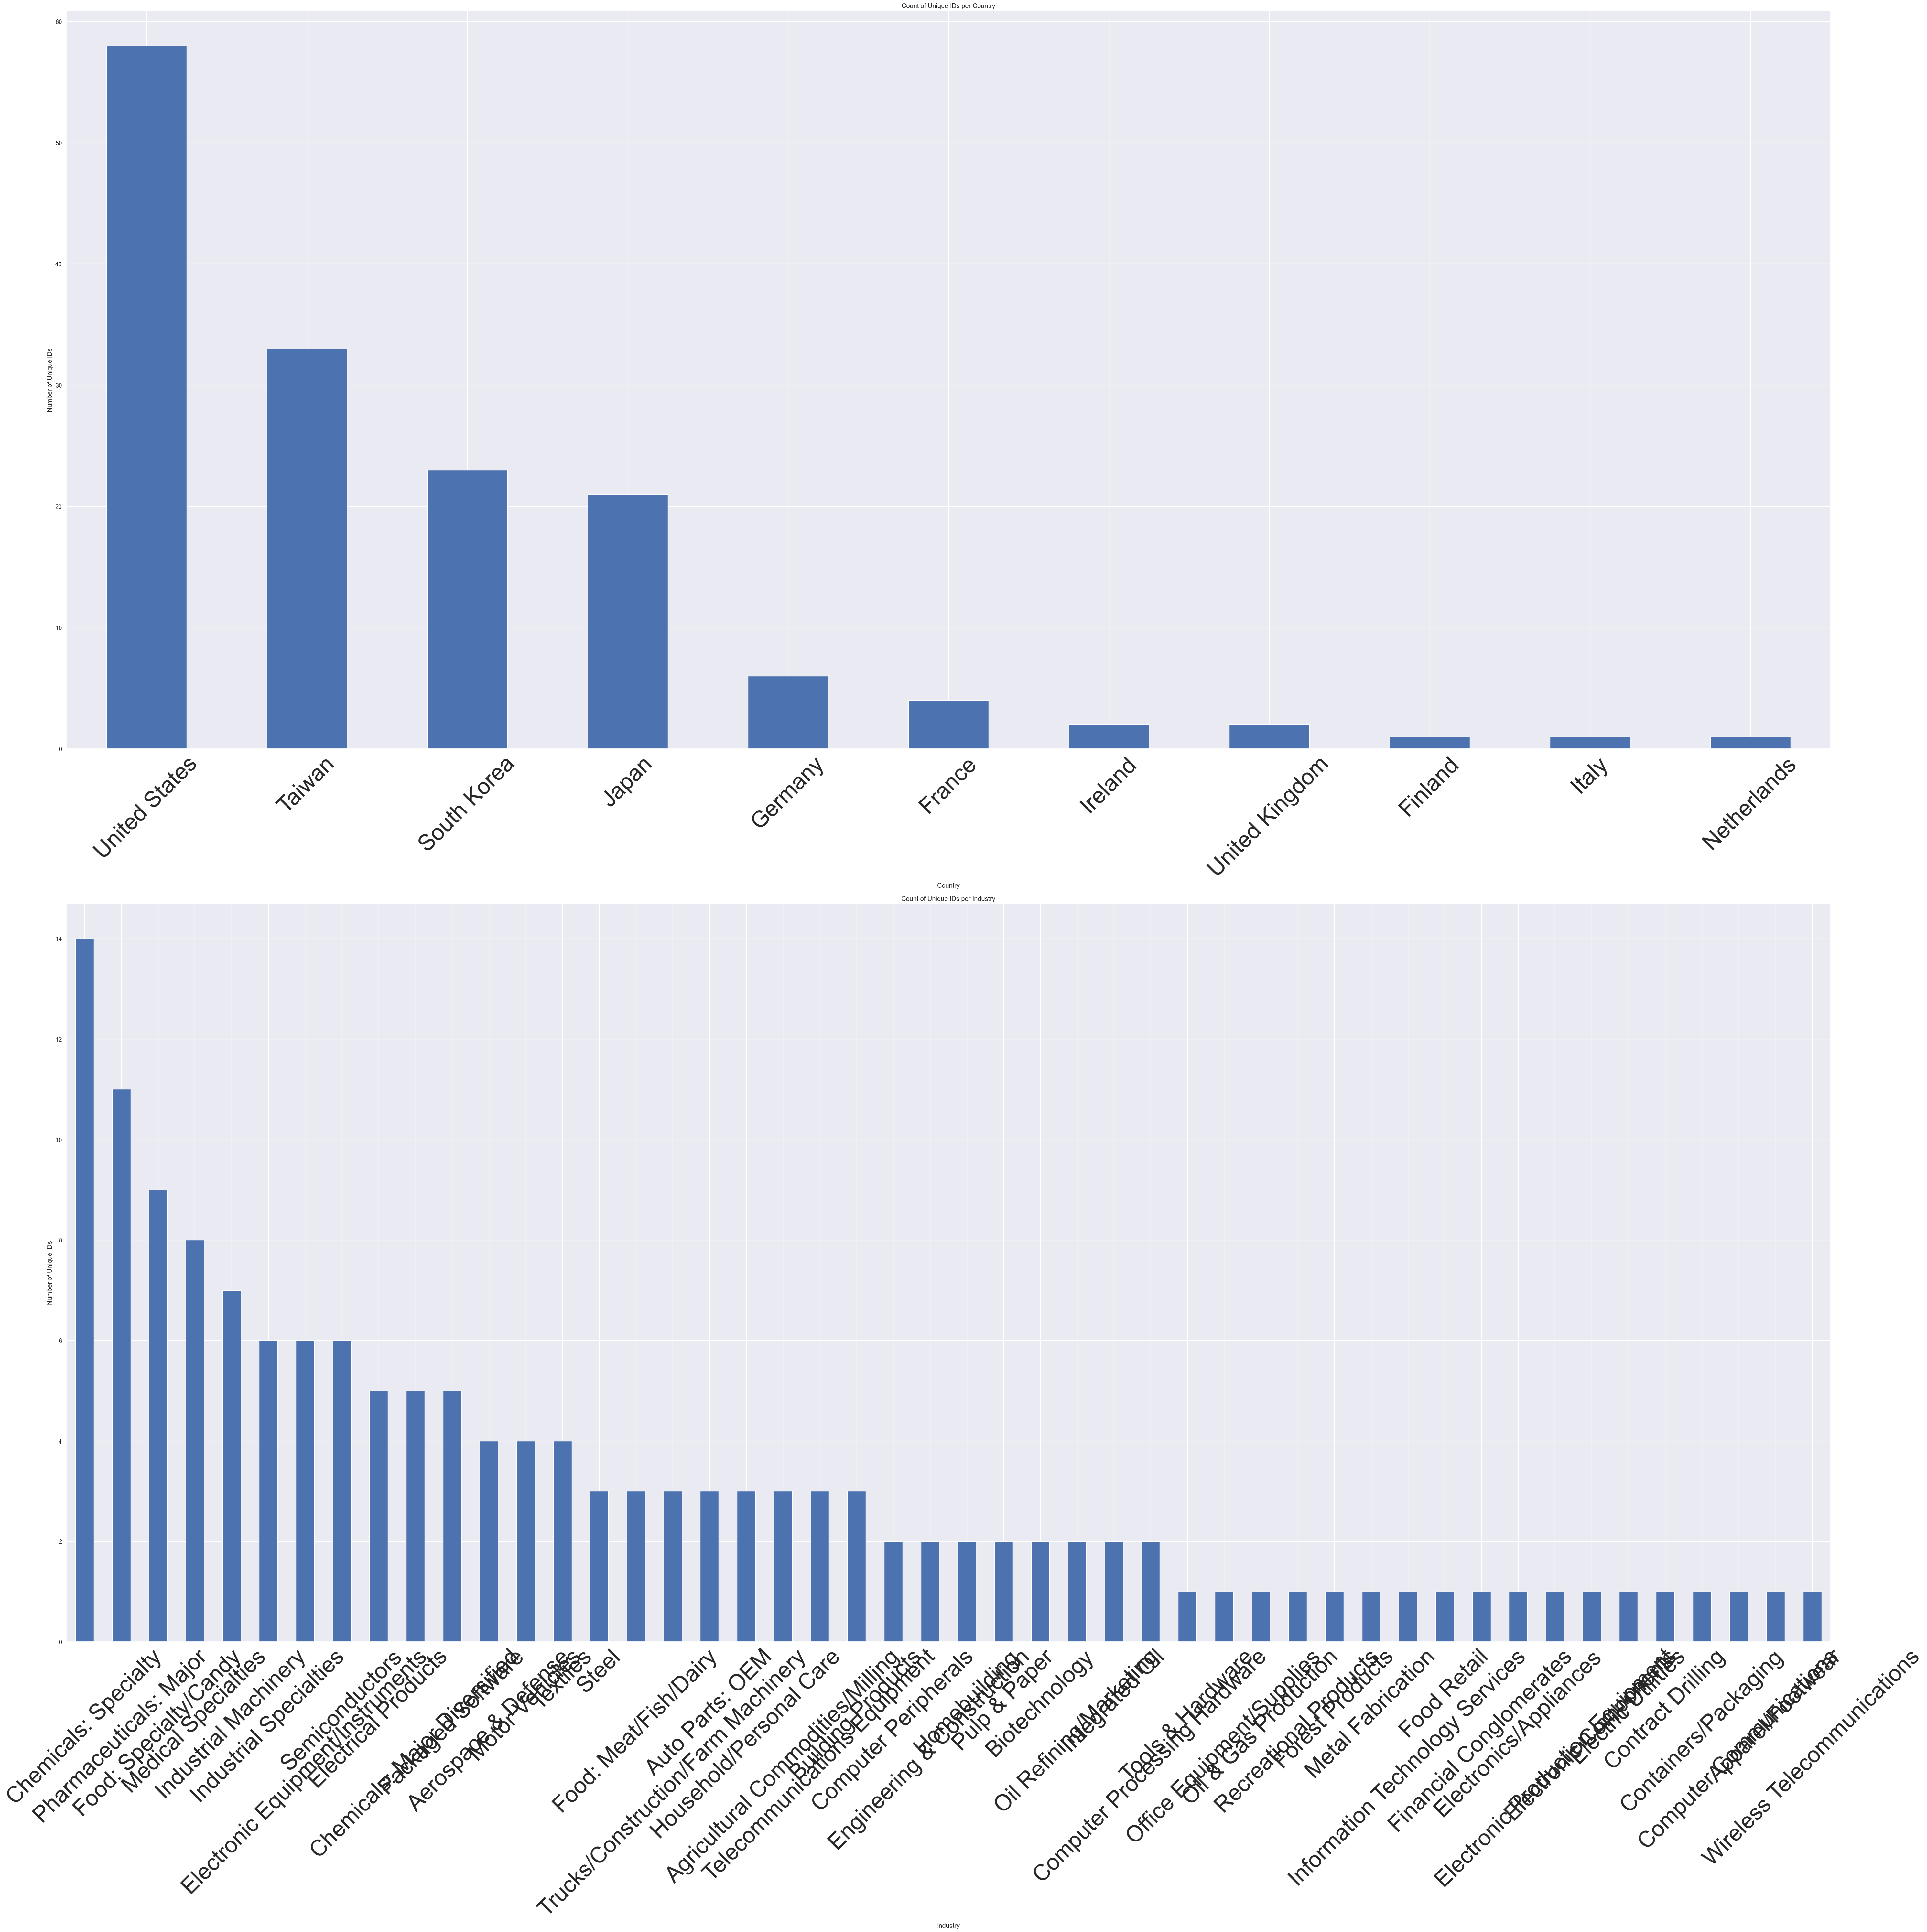

Total number of unique IDs: 152
Total number of countries: 11
Total number of industries: 48

Top 5 countries by number of unique IDs:
Country
United States    58
Taiwan           33
South Korea      23
Japan            21
Germany           6
Name: ID, dtype: int64

Top 5 industries by number of unique IDs:
Industry
Chemicals: Specialty      14
Pharmaceuticals: Major    11
Food: Specialty/Candy      9
Medical Specialties        8
Industrial Machinery       7
Name: ID, dtype: int64


In [6]:
# Set the style for the plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Create a figure with three subplots (1 row, 3 columns)
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(60, 60))

# 2. Count of IDs per Country
country_counts = final_df.groupby('Country')['ID'].nunique().sort_values(ascending=False)
country_counts.plot(kind='bar', ax=ax2)
ax2.set_title('Count of Unique IDs per Country')
ax2.set_xlabel('Country')
ax2.set_ylabel('Number of Unique IDs')
ax2.tick_params(axis='x', rotation=45, labelsize=50)

# 3. Count of IDs per Industry
industry_counts = final_df.groupby('Industry')['ID'].nunique().sort_values(ascending=False)
industry_counts.plot(kind='bar', ax=ax3)
ax3.set_title('Count of Unique IDs per Industry')
ax3.set_xlabel('Industry')
ax3.set_ylabel('Number of Unique IDs')
ax3.tick_params(axis='x', rotation=45, labelsize=50)

plt.tight_layout()
plt.savefig('id_distributions.png', dpi=300)
plt.show()

# Print some summary statistics
print(f"Total number of unique IDs: {final_df['ID'].nunique()}")
print(f"Total number of countries: {final_df['Country'].nunique()}")
print(f"Total number of industries: {final_df['Industry'].nunique()}")

print("\nTop 5 countries by number of unique IDs:")
print(country_counts.head(5))

print("\nTop 5 industries by number of unique IDs:")
print(industry_counts.head(5))

In [ ]:
final_df.head(5)

In [7]:
# Identify the ID and metadata columns
id_cols = ['ID', 'Name', 'Country', 'Industry', 'Feature']

# Before melting, check which year columns actually exist in the DataFrame
# Convert column names to strings before using isdigit()
available_year_cols = [col for col in final_df.columns if str(col).isdigit() and 1998 <= int(str(col)) <= 2024]

# If no year columns are found, you might need to check your column names
if not available_year_cols:
    print("Warning: No year columns found. Available columns:", final_df.columns)

# Perform the melt operation to transpose the data using only available columns
transposed_df = pd.melt(
    final_df,
    id_vars=id_cols,
    value_vars=available_year_cols,  # Use only the year columns that actually exist
    var_name='Year',
    value_name='Feature Value'
)

# Reorder columns to match the requested format
# This puts 'Year' right after 'Feature' and before 'Feature Value'
column_order = id_cols + ['Year', 'Feature Value']
transposed_df = transposed_df[column_order]

# Display the first few rows of the transposed dataframe
print(transposed_df.head())

# Write the result to a new Excel file
output_file = "final_merged_data.xlsx"
transposed_df.to_excel(output_file, index=False)

          ID                               Name      Country  \
0  000070-KR       Samyang Holdings Corporation  South Korea   
1  001040-KR                     CJ Corporation  South Korea   
2  001630-KR  Chong Kun Dang Holdings Co., Ltd.  South Korea   
3  002380-KR                    KCC Corporation  South Korea   
4  003070-KR                  Kolon Global Corp  South Korea   

                           Industry Feature  Year  Feature Value  
0  Agricultural Commodities/Milling      EV  1998      395.81155  
1             Food: Specialty/Candy      EV  1998     1898.89480  
2            Pharmaceuticals: Major      EV  1998      241.31895  
3            Industrial Specialties      EV  1998      436.81866  
4        Engineering & Construction      EV  1998      343.51220  


Smoothing out the data below:

In [8]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
data_smoothed = transposed_df.groupby(['ID','Feature','Year'])[['Feature Value']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([transposed_df[['ID','Name','Country','Industry','Feature','Year']], data_smoothed], axis=1, sort=False)

smoothed_df.head(20)

ID                                Name      Country  \
0   000070-KR        Samyang Holdings Corporation  South Korea   
1   001040-KR                      CJ Corporation  South Korea   
2   001630-KR   Chong Kun Dang Holdings Co., Ltd.  South Korea   
3   002380-KR                     KCC Corporation  South Korea   
4   003070-KR                   Kolon Global Corp  South Korea   
5   003160-KR                      DI Corporation  South Korea   
6   003240-KR       Taekwang Industrial Co., Ltd.  South Korea   
7   004370-KR                  Nongshim Co., Ltd.  South Korea   
8   004800-KR                 Hyosung Corporation  South Korea   
9   005380-KR               Hyundai Motor Company  South Korea   
10  005490-KR                 POSCO Holdings Inc.  South Korea   
11  005930-KR       Samsung Electronics Co., Ltd.  South Korea   
12  005950-KR               ISU CHEMICAL CO. LTD.  South Korea   
13  007210-KR                      Byucksan Corp.  South Korea   
14  009150-KR  Samsung Electro-Mechanics Co., Ltd  South Korea   
15  010140-KR   Samsung Heavy Industries Co., Ltd  South Korea   
16  011780-KR       Kumho Petrochemical Co., Ltd.  South Korea   
17  011790-KR                       SKC Co., Ltd.  South Korea   
18  012800-KR                  DAECHANG Co., Ltd.  South Korea   
19  014820-KR         Dongwon Systems Corporation  South Korea   

                              Industry Feature  Year  Feature Value  
0     Agricultural Commodities/Milling      EV  1998     395.811550  
1                Food: Specialty/Candy      EV  1998    1898.894800  
2               Pharmaceuticals: Major      EV  1998     241.318950  
3               Industrial Specialties      EV  1998     436.818660  
4           Engineering & Construction      EV  1998     343.512200  
5     Electronic Equipment/Instruments      EV  1998      59.457910  
6               Oil Refining/Marketing      EV  1998     548.158900  
7                Food: Specialty/Candy      EV  1998     356.406860  
8              Financial Conglomerates      EV  1998     926.811650  
9                       Motor Vehicles      EV  1998    4465.765600  
10                               Steel      EV  1998   10267.070000  
11        Telecommunications Equipment      EV  1998   21209.020000  
12                Chemicals: Specialty      EV  1998     246.643190  
13                     Forest Products      EV  1998     174.020280  
14                      Semiconductors      EV  1998    2325.170400  
15  Trucks/Construction/Farm Machinery      EV  1998    4147.234000  
16                Chemicals: Specialty      EV  1998     445.005600  
17                Chemicals: Specialty      EV  1998     464.829960  
18                   Metal Fabrication      EV  1998      84.376724  
19             Computer Communications      EV  1998      90.547550

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Transformed EV column to log scale with offset 1.4472441 to handle non-positive values

Original EV statistics:
count      4104.000000
mean      39089.545297
std       76532.535595
min       -1100.691900
25%        1553.574650
50%        9554.662500
75%       38865.417000
max      849523.250000
Name: EV, dtype: float64

Log-transformed EV statistics:
count    4091.000000
mean        8.957229
std         2.109118
min         2.828478
25%         7.384238
50%         9.175845
75%        10.572675
max        13.652433
Name: EV, dtype: float64


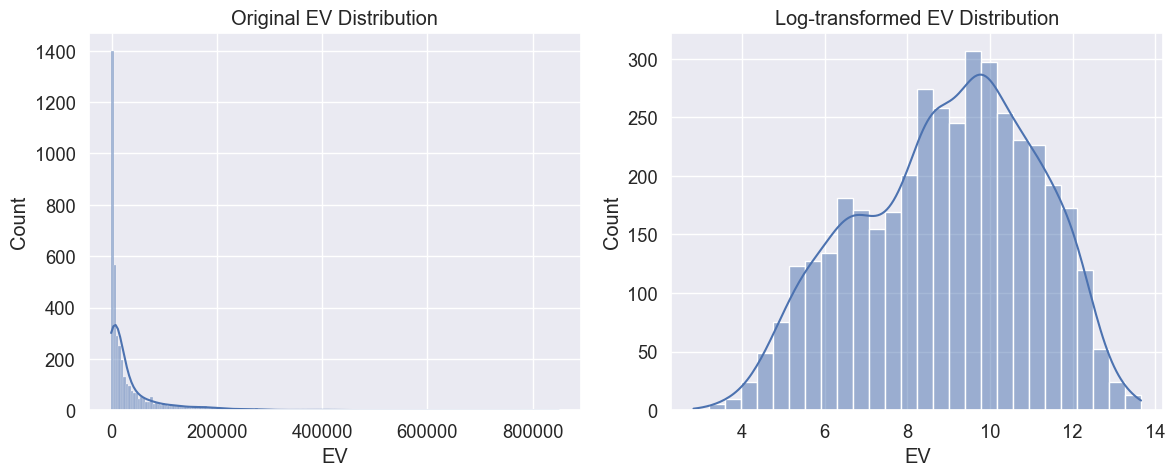

Feature         ID                          Name      Country  \
0        000070-KR  Samyang Holdings Corporation  South Korea   
1        000070-KR  Samyang Holdings Corporation  South Korea   
2        000070-KR  Samyang Holdings Corporation  South Korea   
3        000070-KR  Samyang Holdings Corporation  South Korea   
4        000070-KR  Samyang Holdings Corporation  South Korea   

Feature                          Industry  Year  Asset Turnover         Capex  \
0        Agricultural Commodities/Milling  1998        1.165113  58359.193556   
1        Agricultural Commodities/Milling  1999        0.966797  33588.648349   
2        Agricultural Commodities/Milling  2000        1.045825  41526.467475   
3        Agricultural Commodities/Milling  2001        0.863743  31160.656221   
4        Agricultural Commodities/Milling  2002        0.819234  22888.086356   

Feature  Capex as % of Rev  Cash and Cash Equiv  Debt to Equity  ...  \
0                 5.293495         46472.177661   

In [9]:
# Step 1: Pivot the DataFrame to create columns for each unique Feature value
pivoted_df = smoothed_df.pivot_table(
    index=['ID', 'Name', 'Country', 'Industry', 'Year'],
    columns='Feature',
    values='Feature Value',
    aggfunc='first'  # In case there are duplicates
)

# Step 2: Reset the index to convert index columns back to regular columns
result_df = pivoted_df.reset_index()

# Step 3: Rename columns if needed (optional)
# For example, if you want to add a prefix to all feature columns:
# feature_columns = [col for col in result_df.columns if col not in ['ID', 'Name', 'Country', 'Industry', 'Year']]
# result_df = result_df.rename(columns={col: f"Prediction_{col}" for col in feature_columns})

# Transform EV column to logarithmic scale
# First, check if EV column exists
if 'EV' in result_df.columns:
    # Store original EV values for comparison
    original_EV = result_df['EV'].copy()
    
    # Handle potential negative or zero values before taking log
    if (result_df['EV'] <= 0).any():
        # Find the minimum positive value to use as offset
        min_positive = result_df[result_df['EV'] > 0]['EV'].min()
        offset = min_positive / 10  # Use 10% of minimum as offset
        
        # Replace EV with log transformation
        result_df['EV'] = np.log(result_df['EV'] + offset + 1)
        print(f"Transformed EV column to log scale with offset {offset} to handle non-positive values")
    else:
        # If all values are positive, simply take the log
        result_df['EV'] = np.log(result_df['EV'])
        print("Transformed EV column to log scale (natural logarithm)")
    
    # Display summary statistics of original and transformed columns
    print("\nOriginal EV statistics:")
    print(original_EV.describe())
    
    print("\nLog-transformed EV statistics:")
    print(result_df['EV'].describe())
    
    # Visualize the transformation
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(original_EV, kde=True)
    plt.title('Original EV Distribution')
    
    plt.subplot(1, 2, 2)
    sns.histplot(result_df['EV'], kde=True)
    plt.title('Log-transformed EV Distribution')
    
    plt.tight_layout()
    plt.show()
else:
    print("EV column not found in the dataframe")

# Display the first few rows to verify
print(result_df.head())

# Define columns to use as features
all_X_columns = [col for col in result_df.columns if col not in ['EV','Name','ID']]
print(all_X_columns)

Creating prediction column, which is supposed to link the EV data for each year of the company. We must transform the actual dataframe so there is the new column Prediction EV with the corresponding EV values for the years and companies.

In [10]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(result_df.shape[0], result_df.shape[1]))

# Any row that has a `NaN` value will be dropped.
result_df = result_df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(result_df.shape[0], result_df.shape[1]))

# Print the head.
result_df.head()

Before NaN Drop we have 4104 rows and 29 columns
After NaN Drop we have 4091 rows and 29 columns


Feature         ID                          Name      Country  \
0        000070-KR  Samyang Holdings Corporation  South Korea   
1        000070-KR  Samyang Holdings Corporation  South Korea   
2        000070-KR  Samyang Holdings Corporation  South Korea   
3        000070-KR  Samyang Holdings Corporation  South Korea   
4        000070-KR  Samyang Holdings Corporation  South Korea   

Feature                          Industry  Year  Asset Turnover         Capex  \
0        Agricultural Commodities/Milling  1998        1.165113  58359.193556   
1        Agricultural Commodities/Milling  1999        0.966797  33588.648349   
2        Agricultural Commodities/Milling  2000        1.045825  41526.467475   
3        Agricultural Commodities/Milling  2001        0.863743  31160.656221   
4        Agricultural Commodities/Milling  2002        0.819234  22888.086356   

Feature  Capex as % of Rev  Cash and Cash Equiv  Debt to Equity  ...  \
0                 5.293495         46472.177661      152.755708  ...   
1                 3.457463         57490.282337      115.381785  ...   
2                 3.898446         51704.350251       93.171474  ...   
3                 4.052558         41406.904597       52.960320  ...   
4                 3.800585         36339.984610       38.104834  ...   

Feature  RD Expenses       ROA        ROE       ROIC   SGA Expenses  \
0         488.958952 -1.029155  -4.422767  -2.368204   97701.412254   
1        1040.441357  0.637183   2.066572   1.382386   26798.567988   
2        3608.662735  2.631918   7.214552   5.605777  114232.058721   
3        3160.870951  5.738511  12.148104  10.356357   66687.096630   
4        2693.761810  6.623440  10.987835   9.879798   54093.210609   

Feature         Sales  Sales Growth  Total Assets     Total Debt  \
0        1.102470e+06     21.659698  9.871281e+05  416935.205441   
1        9.714825e+05    -12.476195  9.984657e+05  398208.218145   
2        1.065206e+06      1.119734  1.068650e+06  381727.452767   
3        7.689133e+05    -23.928115  7.462368e+05  229872.585024   
4        6.022254e+05    -16.558548  7.743824e+05  184373.239850   

Feature  Total Liabilities  
0            712288.777057  
1            653060.924842  
2            657903.155320  
3            312190.014369  
4            290524.531904  

[5 rows x 29 columns]

Now, I am going to build the model by splitting and training the data first.

In [11]:
# Step 1: Define your X and Y columns
X_cols = [col for col in result_df.columns if col not in ['EV', 'Name', 'ID']]
Y_cols = ['EV']  # Assuming EV is your target
print(len(X_cols))
print(len(Y_cols))

# Step 2: Split data into training and validation sets
unique_ids = result_df['ID'].unique()
num_companies_to_select = min(30, len(unique_ids))
selected_ids = np.random.choice(unique_ids, size=num_companies_to_select, replace=False)

validation_df = result_df[result_df['ID'].isin(selected_ids)].copy()
train_df = result_df[~result_df['ID'].isin(selected_ids)].copy()

print(f"Selected {len(selected_ids)} unique companies for validation")
print(f"Training set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Validation set: {validation_df.shape[0]} rows, {validation_df.shape[1]} columns")

# Step 3: Identify categorical columns that need encoding
categorical_cols = [col for col in X_cols if train_df[col].dtype == 'object' or train_df[col].dtype.name == 'category']
numerical_cols = [col for col in X_cols if col not in categorical_cols]

print(f"Categorical columns to encode: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Step 4: Apply LabelEncoder to categorical columns
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Create copies to avoid modifying the original dataframes
X_train = train_df[X_cols].copy()
X_val = validation_df[X_cols].copy()

# Dictionary to store the encoders
label_encoders = {}

# Process each categorical column
for col in categorical_cols:
    # Initialize a new encoder for this column
    le = LabelEncoder()
    
    # Fit on training data
    le.fit(train_df[col].astype(str))
    
    # Transform training data
    X_train[col] = le.transform(train_df[col].astype(str))
    
    # Transform validation data - handle unseen categories
    X_val[col] = X_val[col].astype(str).map(lambda x: x if x in le.classes_ else 'unknown')
    
    # For any 'unknown' values, assign a new label or a default one
    if 'unknown' in X_val[col].values:
        # Map 'unknown' to a new index (length of classes)
        unknown_value = len(le.classes_)
        X_val[col] = X_val[col].map(lambda x: unknown_value if x == 'unknown' else le.transform([x])[0])
    else:
        # If no unknowns, just transform
        X_val[col] = le.transform(X_val[col])
    
    # Store the encoder
    label_encoders[col] = le

# Extract target variables
Y_train = train_df[Y_cols]
Y_val = validation_df[Y_cols]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

26
1
Selected 30 unique companies for validation
Training set: 3281 rows, 29 columns
Validation set: 810 rows, 29 columns
Categorical columns to encode: ['Country', 'Industry']
Numerical columns: ['Year', 'Asset Turnover', 'Capex', 'Capex as % of Rev', 'Cash and Cash Equiv', 'Debt to Equity', 'EBITDA', 'Equity', 'Free Cash Flow', 'Gross Margin', 'Market Cap', 'Net Income', 'Profit Margin', 'Quick Ratio', 'RD Expenses', 'ROA', 'ROE', 'ROIC', 'SGA Expenses', 'Sales', 'Sales Growth', 'Total Assets', 'Total Debt', 'Total Liabilities']
X_train shape: (3281, 26)
X_val shape: (810, 26)


In [12]:
print(len(X_train))
print(len(Y_train))

3281
3281


We are going to undergo cross-validation across different companies.

/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training MSE: 0.0121
Testing MSE: 0.0859
R² Score: 0.9811
Adjusted R² Score: 0.9803

===== MODEL PERFORMANCE METRICS =====
Mean Squared Error (MSE): 0.0269
Root Mean Squared Error (RMSE): 0.1640
Mean Absolute Error (MAE): 0.0969
R² Score: 0.9942
Mean Absolute Percentage Error (MAPE): 1.15%
Mean of Residuals: 0.0035
Standard Deviation of Residuals: 0.1640

===== Sample Predictions =====


Actual  Predicted  Absolute Error  Percentage Error
0   7.005403   6.987951        0.017452          0.249126
1   8.609411   8.615688        0.006276          0.072899
2   5.518033   5.499502        0.018532          0.335841
3   8.990570   8.893812        0.096758          1.076217
4   7.914839   7.945698        0.030859          0.389886
5  11.744637  11.690830        0.053807          0.458139
6   9.941480   9.948183        0.006704          0.067432
7   7.052327   6.975733        0.076593          1.086072
8  11.255571  11.153991        0.101580          0.902487
9   9.757677  10.125037        0.367360          3.764830


===== Industry Error Summary (with Count, Share, and EV) =====


Industry  MeanAbsError  StdAbsError  \
15               Electronic Components      0.222559     0.264639   
40        Telecommunications Equipment      0.206736     0.264705   
33              Oil Refining/Marketing      0.203980     0.295608   
10        Computer Processing Hardware      0.177837     0.162832   
44         Wireless Telecommunications      0.177541     0.169415   
38                      Semiconductors      0.175853     0.210809   
2                     Apparel/Footwear      0.163974     0.204188   
43  Trucks/Construction/Farm Machinery      0.155808     0.205586   
9                 Computer Peripherals      0.151942     0.162055   
18              Electronics/Appliances      0.132223     0.246098   
12                   Contract Drilling      0.129531     0.145963   
4                        Biotechnology      0.127034     0.112791   
34                   Packaged Software      0.123017     0.139555   
13                  Electric Utilities      0.117207     0.166131   
26                Industrial Machinery      0.115528     0.118146   
20             Financial Conglomerates      0.115058     0.100277   
31                   Metal Fabrication      0.113024     0.113205   
37               Recreational Products      0.103891     0.095784   
35              Pharmaceuticals: Major      0.093758     0.099921   
7                 Chemicals: Specialty      0.093146     0.171513   
30                 Medical Specialties      0.089700     0.094499   
19          Engineering & Construction      0.085311     0.097943   
3                      Auto Parts: OEM      0.083939     0.066682   
5                    Building Products      0.081300     0.105648   
22               Food: Meat/Fish/Dairy      0.080593     0.093315   
24                        Homebuilding      0.080277     0.057745   
32                      Motor Vehicles      0.078355     0.083827   
0                  Aerospace & Defense      0.078072     0.075568   
36                        Pulp & Paper      0.075758     0.076421   
16    Electronic Equipment/Instruments      0.072759     0.100916   
25             Household/Personal Care      0.071205     0.064627   
39                               Steel      0.071194     0.059947   
6         Chemicals: Major Diversified      0.070462     0.079149   
1     Agricultural Commodities/Milling      0.070458     0.087558   
23               Food: Specialty/Candy      0.069813     0.065164   
14                 Electrical Products      0.066412     0.062520   
27              Industrial Specialties      0.061026     0.062704   
17     Electronic Production Equipment      0.058505     0.071244   
29                      Integrated Oil      0.056060     0.051559   
42                    Tools & Hardware      0.055560     0.042299   
11                Containers/Packaging      0.053780     0.033686   
8              Computer Communications      0.051686     0.055824   
28     Information Technology Services      0.048485     0.063925   
41                            Textiles      0.043861     0.041434   
21                         Food Retail      0.032430     0.016959   

    MeanPctError  StdPctError  MeanResidual  StdResidual  Count  \
15      2.210057     2.604241      0.076676     0.339656     27   
40      1.887708     2.544072     -0.079138     0.327466     54   
33      3.334821     6.903137     -0.134516     0.333763     48   
10      3.543594     3.657787     -0.136602     0.199947     27   
44      1.836082     1.762028     -0.151886     0.193592     27   
38      1.815753     2.131898      0.000476     0.274875    162   
2       1.595706     1.837610      0.124214     0.231499     27   
43      1.819408     2.666029     -0.054486     0.252948     53   
9       1.955671     2.073553     -0.131888     0.179368     27   
18      2.923357     5.457367     -0.009409     0.280406     27   
12      1.159995     1.273045      0.068794     0.183886     27   
4       1.233659     1.230910      0.061051     0.1

/var/folders/rw/tny5x7_92312zbndrqtmw2dh0000gn/T/ipykernel_44172/821417271.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


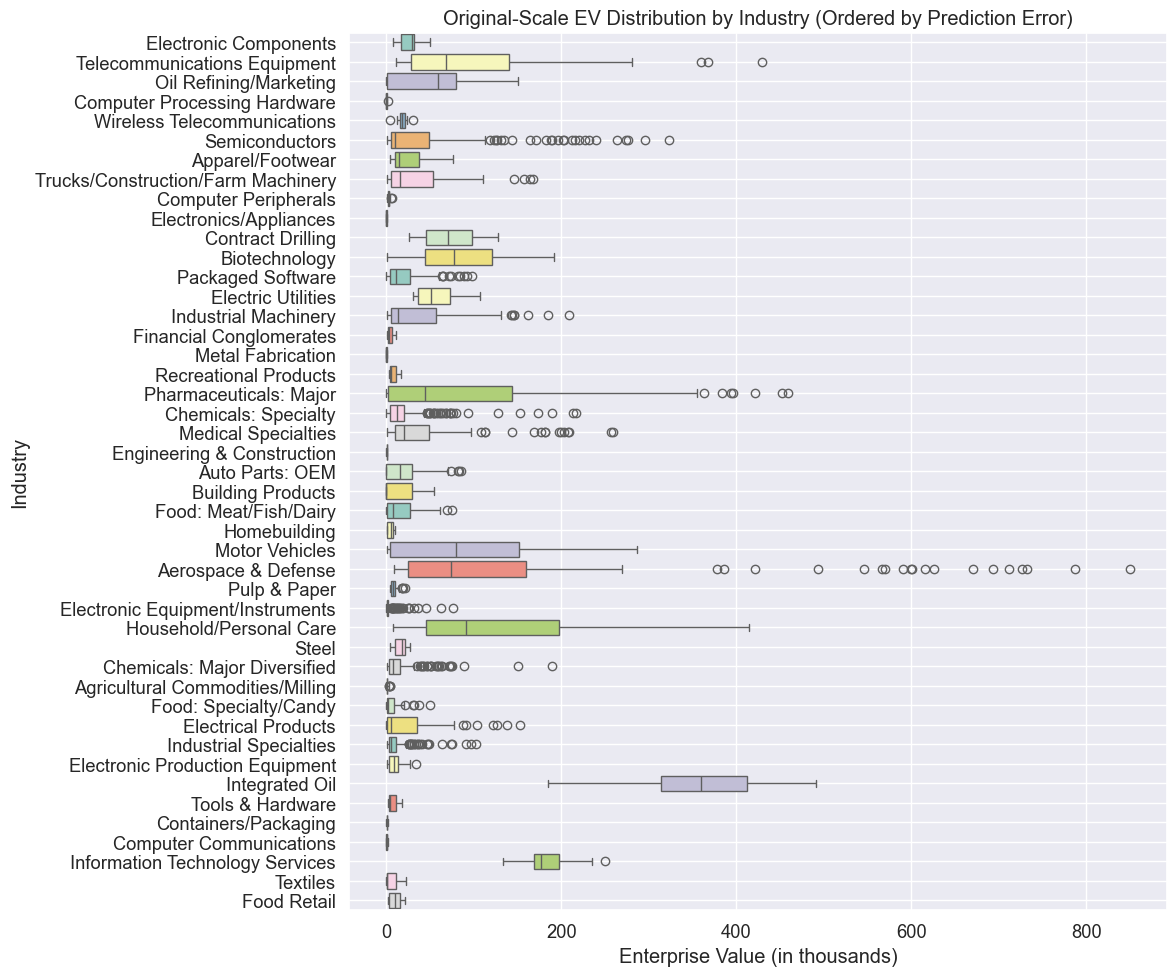


===== OLS Regression Analysis =====


Feature         Coef.      Std.Err.          t         P>|t|  \
0                 const -4.026158e+01  6.756953e+00  -5.958540  2.816923e-09   
1               Country  1.848962e-03  1.042272e-02   0.177397  8.592074e-01   
2              Industry  2.761053e-03  1.945150e-03   1.419455  1.558622e-01   
3                  Year  2.367988e-02  3.352554e-03   7.063236  1.980552e-12   
4        Asset Turnover -6.652099e-01  8.375341e-02  -7.942481  2.705698e-15   
5                 Capex -1.054603e-07  1.624784e-08  -6.490723  9.841659e-11   
6     Capex as % of Rev  2.921766e-02  3.516506e-03   8.308720  1.402612e-16   
7   Cash and Cash Equiv -3.936277e-08  5.406934e-09  -7.280054  4.164252e-13   
8        Debt to Equity  2.857922e-03  3.988342e-04   7.165689  9.531159e-13   
9                EBITDA  1.255370e-08  1.391941e-08   0.901885  3.671849e-01   
10               Equity -4.371855e-07  7.510203e-07  -0.582122  5.605247e-01   
11       Free Cash Flow  4.190839e-08  1.283750e-08   3.264528  1.107815e-03   
12         Gross Margin  8.965966e-03  8.493203e-04  10.556638  1.223472e-25   
13           Market Cap  7.531010e-06  1.182066e-06   6.371059  2.141466e-10   
14           Net Income -1.834089e-07  1.520346e-08 -12.063632  8.157933e-33   
15        Profit Margin  7.749803e-03  4.458869e-03   1.738065  8.229404e-02   
16          Quick Ratio  7.495538e-03  3.293710e-02   0.227571  8.199938e-01   
17          RD Expenses -5.963587e-08  2.209609e-08  -2.698933  6.992160e-03   
18                  ROA  4.603080e-02  1.576618e-02   2.919591  3.528977e-03   
19                  ROE  2.126152e-02  4.246171e-03   5.007222  5.815878e-07   
20                 ROIC  1.088309e-02  1.021448e-02   1.065457  2.867483e-01   
21         SGA Expenses  1.191989e-07  9.489638e-09  12.560954  2.260461e-35   
22                Sales  2.232251e-08  2.329549e-09   9.582330  1.816848e-21   
23         Sales Growth -1.408242e-03  5.806338e-04  -2.425353  1.534757e-02   
24         Total Assets  4.605143e-07  7.510614e-07   0.613151  5.398191e-01   
25           Total Debt -3.566915e-09  4.087903e-09  -0.872554  3.829707e-01   
26    Total Liabilities -4.614990e-07  7.511407e-07  -0.614398  5.389956e-01   

          [0.025        0.975]  
0  -5.350989e+01 -2.701327e+01  
1  -1.858680e-02  2.228472e-02  
2  -1.052790e-03  6.574895e-03  
3   1.710655e-02  3.025321e-02  
4  -8.294247e-01 -5.009952e-01  
5  -1.373173e-07 -7.360321e-08  
6   2.232287e-02  3.611245e-02  
7  -4.996411e-08 -2.876143e-08  
8   2.075930e-03  3.639913e-03  
9  -1.473799e-08  3.984539e-08  
10 -1.909706e-06  1.035335e-06  
11  1.673798e-08  6.707879e-08  
12  7.300710e-03  1.063122e-02  
13  5.213342e-06  9.848678e-06  
14 -2.132183e-07 -1.535996e-07  
15 -9.926727e-04  1.649228e-02  
16 -5.708401e-02  7.207508e-02  
17 -1.029595e-07 -1.631222e-08  
18  1.511815e-02  7.694345e-02  
19  1.293608e-02  2.958696e-02  
20 -9.144376e-03  3.091056e-02  
21  1.005926e-07  1.378052e-07  
22  1.775498e-08  2.689004e-08  
23 -2.546687e-03 -2.697972e-04  
24 -1.012087e-06  1.933115e-06  
25 -1.158204e-08  4.448209e-09  
26 -1.934256e-06  1.011257e-06


===== Significant Variables (p < 0.05) =====


Feature         Coef.      Std.Err.          t         P>|t|  \
21         SGA Expenses  1.191989e-07  9.489638e-09  12.560954  2.260461e-35   
14           Net Income -1.834089e-07  1.520346e-08 -12.063632  8.157933e-33   
12         Gross Margin  8.965966e-03  8.493203e-04  10.556638  1.223472e-25   
22                Sales  2.232251e-08  2.329549e-09   9.582330  1.816848e-21   
6     Capex as % of Rev  2.921766e-02  3.516506e-03   8.308720  1.402612e-16   
4        Asset Turnover -6.652099e-01  8.375341e-02  -7.942481  2.705698e-15   
7   Cash and Cash Equiv -3.936277e-08  5.406934e-09  -7.280054  4.164252e-13   
8        Debt to Equity  2.857922e-03  3.988342e-04   7.165689  9.531159e-13   
3                  Year  2.367988e-02  3.352554e-03   7.063236  1.980552e-12   
5                 Capex -1.054603e-07  1.624784e-08  -6.490723  9.841659e-11   
13           Market Cap  7.531010e-06  1.182066e-06   6.371059  2.141466e-10   
0                 const -4.026158e+01  6.756953e+00  -5.958540  2.816923e-09   
19                  ROE  2.126152e-02  4.246171e-03   5.007222  5.815878e-07   
11       Free Cash Flow  4.190839e-08  1.283750e-08   3.264528  1.107815e-03   
18                  ROA  4.603080e-02  1.576618e-02   2.919591  3.528977e-03   
17          RD Expenses -5.963587e-08  2.209609e-08  -2.698933  6.992160e-03   
23         Sales Growth -1.408242e-03  5.806338e-04  -2.425353  1.534757e-02   

          [0.025        0.975]  
21  1.005926e-07  1.378052e-07  
14 -2.132183e-07 -1.535996e-07  
12  7.300710e-03  1.063122e-02  
22  1.775498e-08  2.689004e-08  
6   2.232287e-02  3.611245e-02  
4  -8.294247e-01 -5.009952e-01  
7  -4.996411e-08 -2.876143e-08  
8   2.075930e-03  3.639913e-03  
3   1.710655e-02  3.025321e-02  
5  -1.373173e-07 -7.360321e-08  
13  5.213342e-06  9.848678e-06  
0  -5.350989e+01 -2.701327e+01  
19  1.293608e-02  2.958696e-02  
11  1.673798e-08  6.707879e-08  
18  1.511815e-02  7.694345e-02  
17 -1.029595e-07 -1.631222e-08  
23 -2.546687e-03 -2.697972e-04


===== Variance Inflation Factors (VIF) =====


Feature           VIF  HighVIF
0               Country  1.255783e+01     True
1              Industry  4.420990e+00    False
2                  Year  3.386091e+01     True
3        Asset Turnover  9.570697e+00    False
4                 Capex  9.119579e+00    False
5     Capex as % of Rev  2.473401e+00    False
6   Cash and Cash Equiv  5.163038e+00    False
7        Debt to Equity  3.680626e+00    False
8                EBITDA  3.088496e+01     True
9                Equity  8.998630e+05     True
10       Free Cash Flow  3.219883e+00    False
11         Gross Margin  2.810971e+00    False
12           Market Cap  4.848219e+00    False
13           Net Income  9.404976e+00    False
14        Profit Margin  6.114017e+00    False
15          Quick Ratio  4.709648e+00    False
16          RD Expenses  6.165424e+00    False
17                  ROA  2.811017e+01     True
18                  ROE  1.294876e+01     True
19                 ROIC  3.224066e+01     True
20         SGA Expenses  1.142671e+01     True
21                Sales  2.197237e+01     True
22         Sales Growth  1.066172e+00    False
23         Total Assets  7.498945e+06     True
24           Total Debt  3.815822e+01     True
25    Total Liabilities  3.876781e+06     True


⚠️ Warning: Some features have VIF > 10, indicating possible multicollinearity.


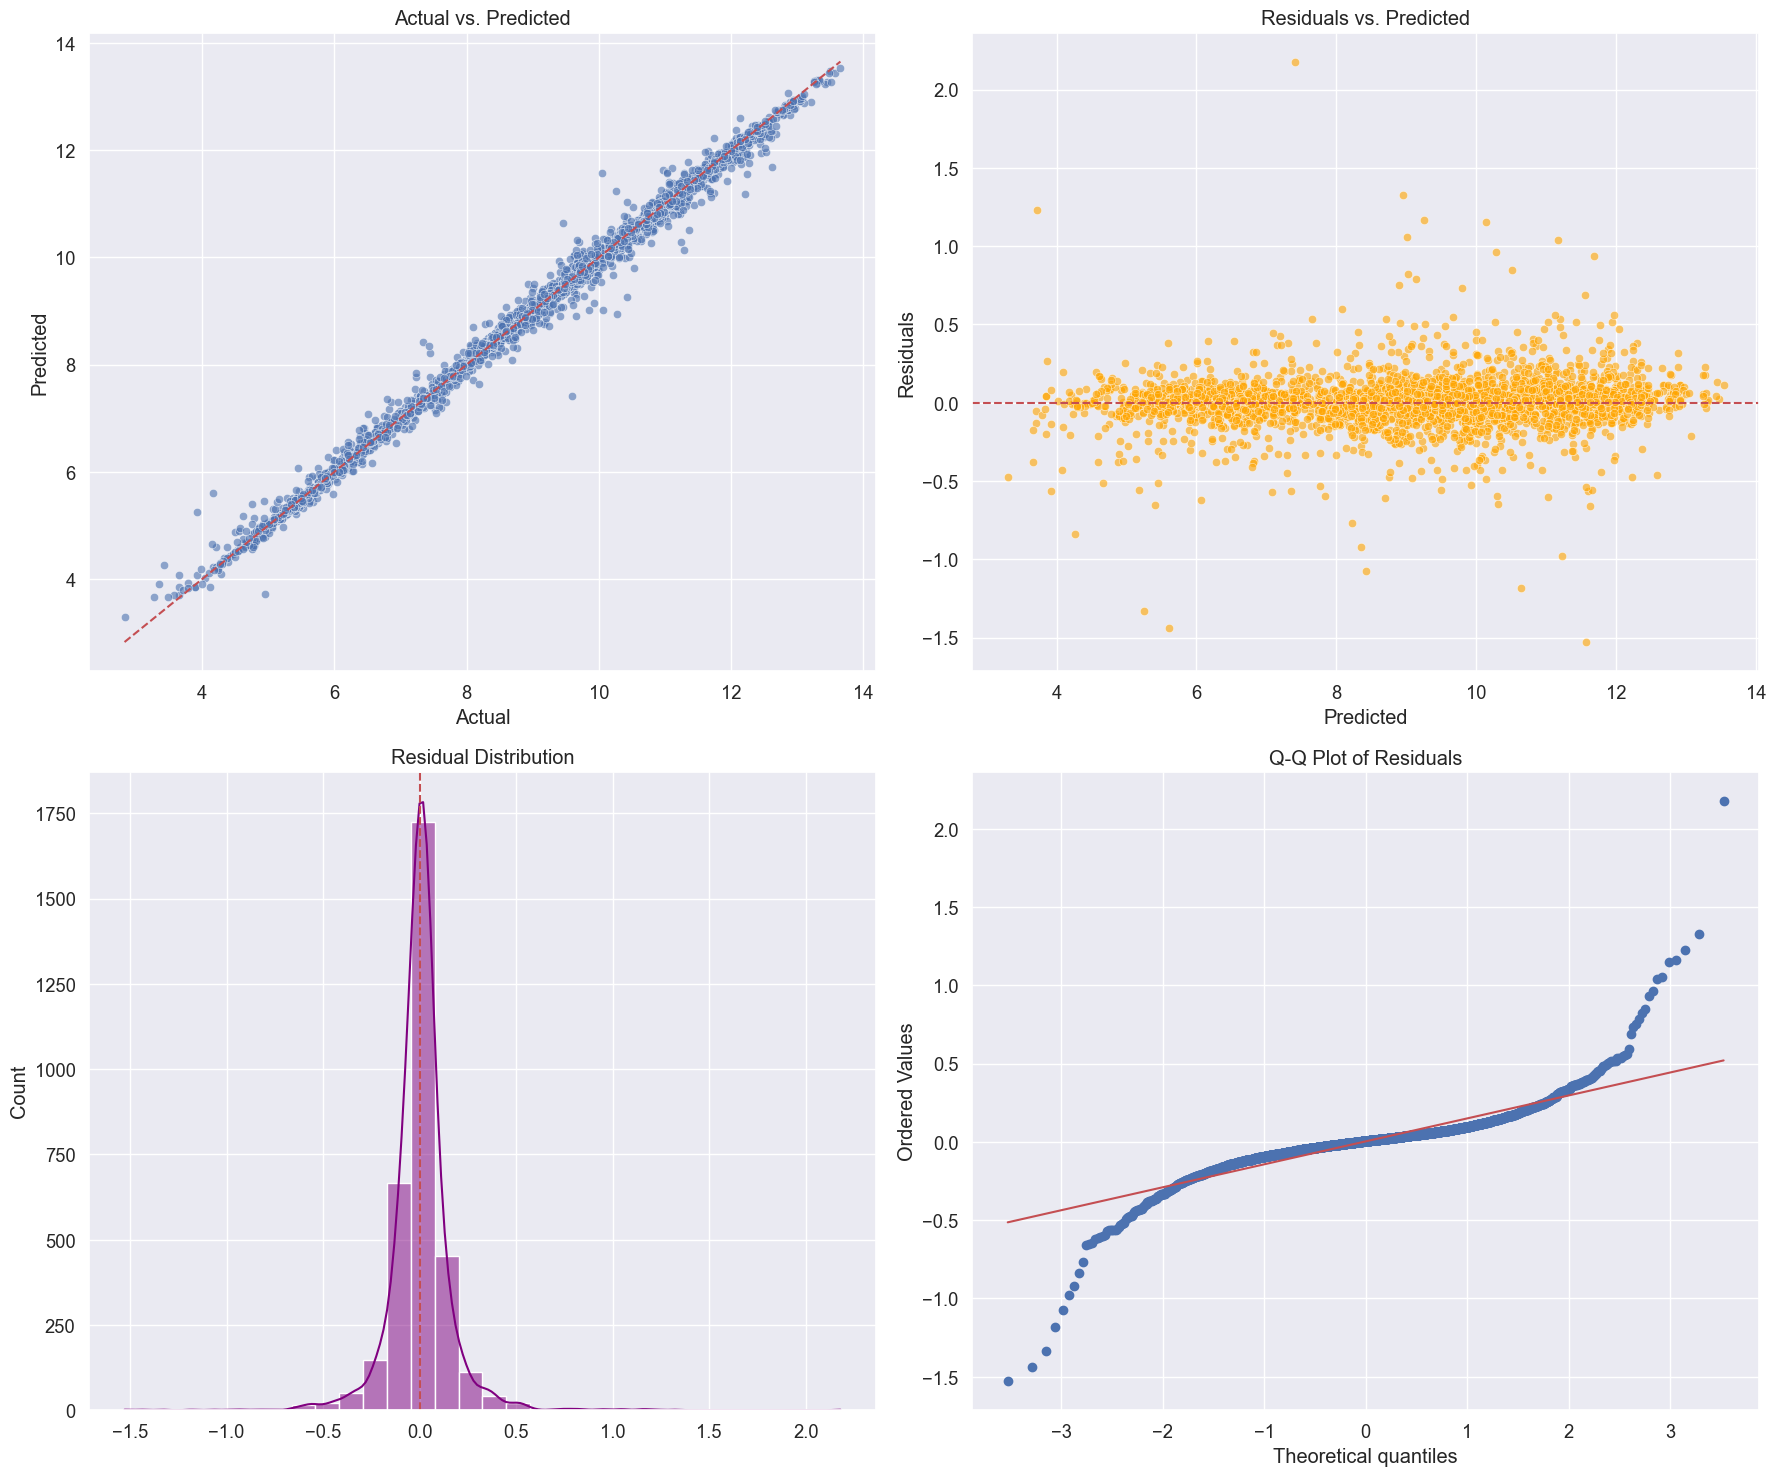

/var/folders/rw/tny5x7_92312zbndrqtmw2dh0000gn/T/ipykernel_44172/821417271.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=vif_data.sort_values("VIF", ascending=False), palette="viridis")


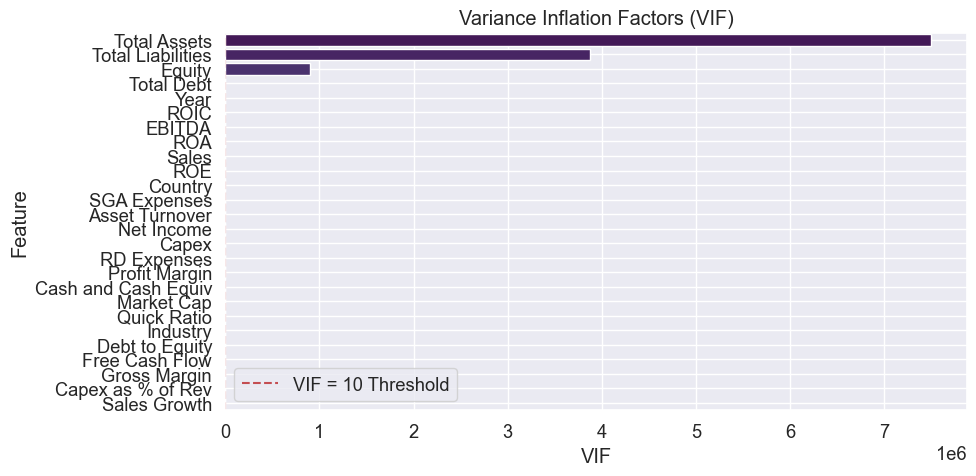

In [22]:
# Import necessary libraries
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Make sure X_train and Y_train have the same number of samples before splitting
# This step assumes X_train and Y_train are defined elsewhere and have different lengths
min_samples = min(len(X_train), len(Y_train))
X_train = X_train[:min_samples]
Y_train = Y_train[:min_samples]

# Define a function to train and evaluate the model
def train_random_forest_model(X_train, Y_train):
    # Split data into training and testing sets
    X_train_split, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
    
    # Initialize and train the Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_split, y_train)
    
    # Make predictions
    train_predictions = model.predict(X_train_split)
    test_predictions = model.predict(X_test)
    
    # Evaluate the model
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    r2 = r2_score(y_test, test_predictions)
    
    # Calculate adjusted R-squared
    n = len(y_test)  # number of observations
    p = X_test.shape[1]  # number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Testing MSE: {test_mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Adjusted R² Score: {adjusted_r2:.4f}")
    
    return model, (X_test, y_test)  # Return model and test data for further evaluation

# Train the model and get predictions
model, (X_test, y_test) = train_random_forest_model(X_train, Y_train)

def compare_predictions(model, X, Y_actual, industry_column, num_samples=10):
    """
    Compare model predictions with actual values, including:
    - Performance metrics
    - Sample predictions
    - Residual analysis
    - Error analysis by industry
    - OLS regression analysis for statistical significance
    - Variance Inflation Factor (VIF) for multicollinearity

    Parameters:
    model: Trained regressor (e.g., RandomForestRegressor or LinearRegression)
    X: Feature DataFrame
    Y_actual: Actual target values (Series or array)
    industry_column: Series with industry labels (must align with X)
    num_samples: Number of samples to display in prediction table
    """

    # === LIBRARIES ===
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from scipy import stats
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    try:
        from IPython.display import display
    except ImportError:
        def display(df):
            print(df.to_string())

    # === DISPLAY HELPER ===
    def display_dataframe_to_user(name, dataframe):
        print(f"\n===== {name} =====")
        display(dataframe)

    # === VALIDATIONS ===
    assert len(industry_column) == len(X), "❌ Industry column must match number of samples in X."
    assert all(np.issubdtype(dt, np.number) for dt in X.dtypes), "❌ All columns in X must be numeric for regression and VIF."

    # === PREDICTIONS ===
    Y_pred_array = model.predict(X).ravel()
    Y_actual_array = Y_actual.values.ravel() if hasattr(Y_actual, 'values') else np.array(Y_actual).ravel()

    # === METRICS ===
    residuals = Y_actual_array - Y_pred_array
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_errors = np.abs((Y_actual_array - Y_pred_array) / Y_actual_array) * 100
    mape = np.nanmean(percentage_errors[~np.isinf(percentage_errors)])
    mse = mean_squared_error(Y_actual_array, Y_pred_array)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_actual_array, Y_pred_array)
    r2 = r2_score(Y_actual_array, Y_pred_array)
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # === PERFORMANCE REPORT ===
    print("\n===== MODEL PERFORMANCE METRICS =====")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Mean of Residuals: {mean_residual:.4f}")
    print(f"Standard Deviation of Residuals: {std_residual:.4f}")

    # === SAMPLE PREDICTIONS ===
    indices = np.random.choice(len(Y_actual_array), min(num_samples, len(Y_actual_array)), replace=False)
    comparison_df = pd.DataFrame({
        'Actual': Y_actual_array[indices],
        'Predicted': Y_pred_array[indices],
        'Absolute Error': np.abs(Y_actual_array[indices] - Y_pred_array[indices])
    })

    with np.errstate(divide='ignore', invalid='ignore'):
        comparison_df['Percentage Error'] = np.abs(
            (Y_actual_array[indices] - Y_pred_array[indices]) / Y_actual_array[indices]
        ) * 100
        comparison_df['Percentage Error'] = comparison_df['Percentage Error'].replace([np.inf, -np.inf], np.nan)

    display_dataframe_to_user("Sample Predictions", comparison_df)

    # === INDUSTRY ERROR ANALYSIS WITH TEMPORARY DECODING + COUNT SHARE + SUM EV ===
    from sklearn.preprocessing import LabelEncoder
    
    grouping_var = "Industry"
    
    # Safe decoding: only apply inverse_transform if values are integers
    industry_input = industry_column[grouping_var]
    
    # Check if decoding is needed (dtype is integer and encoder exists)
    if "Industry" in label_encoders and np.issubdtype(industry_input.dtype, np.integer):
        industry_encoder = label_encoders["Industry"]
        
        # Handle unseen values safely
        encoded_vals = industry_input.values
        valid_mask = encoded_vals < len(industry_encoder.classes_)
        
        # Assign "Unknown" to out-of-range values
        industry_decoded = np.full(encoded_vals.shape, "Unknown", dtype=object)
        industry_decoded[valid_mask] = industry_encoder.inverse_transform(encoded_vals[valid_mask])
    else:
        # Already decoded, just use as-is
        industry_decoded = industry_input.values
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'Actual': Y_actual_array,   # assumed to be EV
        'Predicted': Y_pred_array,
        'Residual': residuals,
        'AbsError': np.abs(residuals),
        'PercentageError': percentage_errors,
        'Industry': industry_decoded
    })
    
    # Count and share of each industry
    industry_counts = results_df["Industry"].value_counts().reset_index()
    industry_counts.columns = ["Industry", "Count"]
    total_count = industry_counts["Count"].sum()
    industry_counts["ShareOfTotal (%)"] = (industry_counts["Count"] / total_count) * 100
    
    # Sum of EV per industry
    ev_sum = results_df.groupby("Industry")["Actual"].sum().reset_index()
    ev_sum.columns = ["Industry", "SumEV"]
    
    # Group and aggregate performance metrics
    industry_summary = results_df.groupby("Industry").agg({
        "AbsError": ["mean", "std"],
        "PercentageError": ["mean", "std"],
        "Residual": ["mean", "std"]
    }).reset_index()
    
    # Rename columns
    industry_summary.columns = ['Industry', 'MeanAbsError', 'StdAbsError',
                                'MeanPctError', 'StdPctError',
                                'MeanResidual', 'StdResidual']
    
    # Merge counts, share, and EV into summary
    industry_summary = industry_summary.merge(industry_counts, on="Industry")
    industry_summary = industry_summary.merge(ev_sum, on="Industry")
    
    # Sort by MeanAbsError
    industry_summary = industry_summary.sort_values(by="MeanAbsError", ascending=False)
    
    # Display
    display_dataframe_to_user("Industry Error Summary (with Count, Share, and EV)", industry_summary)

    # Prepare boxplot DataFrame
    # === UNLOGGING EV VALUES TEMPORARILY ===
    # === UNLOGGING EV VALUES TEMPORARILY ===
    EV_unlogged = np.exp(Y_actual_array)  # or use np.expm1(Y_actual_array) if log1p was used
    
    # Create DataFrame for plotting
    ev_boxplot_df = pd.DataFrame({
        "EV": EV_unlogged / 1e3,  # Convert to thousands
        "Industry": industry_decoded
    })
    
    # Order industries by prediction error (already sorted in industry_summary)
    industry_order_by_error = industry_summary.sort_values(by="MeanAbsError", ascending=False)["Industry"]
    
    # Plot boxplots
    plt.figure(figsize=(12, 10))
    sns.boxplot(
        x="EV",
        y="Industry",
        data=ev_boxplot_df,
        order=industry_order_by_error,
        palette="Set3",
        showfliers=True
    )
    plt.title("Original-Scale EV Distribution by Industry (Ordered by Prediction Error)")
    plt.xlabel("Enterprise Value (in thousands)")
    plt.ylabel("Industry")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === OLS REGRESSION ANALYSIS ===
    X_with_const = sm.add_constant(X)
    ols_model = sm.OLS(Y_actual_array, X_with_const).fit()
    ols_summary_df = ols_model.summary2().tables[1].reset_index().rename(columns={"index": "Feature"})
    display_dataframe_to_user("OLS Regression Analysis", ols_summary_df)

    # === STATISTICALLY SIGNIFICANT VARIABLES (p < 0.05) ===
    significant_vars = ols_summary_df[ols_summary_df["P>|t|"] < 0.05].copy()
    significant_vars = significant_vars.sort_values("P>|t|")
    display_dataframe_to_user("Significant Variables (p < 0.05)", significant_vars)

    # === MULTICOLLINEARITY CHECK (VIF) ===
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data["HighVIF"] = vif_data["VIF"] > 10
    display_dataframe_to_user("Variance Inflation Factors (VIF)", vif_data)

    if vif_data["HighVIF"].any():
        print("\n⚠️ Warning: Some features have VIF > 10, indicating possible multicollinearity.")

    # === VISUALIZATIONS ===
    plt.figure(figsize=(18, 15))

    # 1. Actual vs Predicted
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=Y_actual_array, y=Y_pred_array, alpha=0.6)
    plt.plot([Y_actual_array.min(), Y_actual_array.max()],
             [Y_actual_array.min(), Y_actual_array.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs. Predicted")
    plt.grid(True)

    # 2. Residuals vs Predicted
    plt.subplot(2, 2, 2)
    sns.scatterplot(x=Y_pred_array, y=residuals, alpha=0.6, color='orange')
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Predicted")
    plt.grid(True)

    # 3. Residual histogram + KDE
    plt.subplot(2, 2, 3)
    sns.histplot(residuals, bins=30, kde=True, color='purple')
    plt.axvline(0, color='r', linestyle='--')
    plt.title("Residual Distribution")

    # 4. Q-Q plot of residuals
    plt.subplot(2, 2, 4)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")

    plt.tight_layout()
    plt.show()

    # === VIF Visualization ===
    plt.figure(figsize=(10, 5))
    sns.barplot(x="VIF", y="Feature", data=vif_data.sort_values("VIF", ascending=False), palette="viridis")
    plt.axvline(10, color='r', linestyle='--', label='VIF = 10 Threshold')
    plt.title("Variance Inflation Factors (VIF)")
    plt.xlabel("VIF")
    plt.ylabel("Feature")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Compare predictions with actual values on test data
test_predictions = compare_predictions(model, X_train, Y_train,X_train)



===== MODEL PERFORMANCE METRICS =====
Mean Squared Error (MSE): 0.1277
Root Mean Squared Error (RMSE): 0.3573
Mean Absolute Error (MAE): 0.2625
R² Score: 0.9663
Mean Absolute Percentage Error (MAPE): 3.03%
Mean of Residuals: -0.0148
Standard Deviation of Residuals: 0.3570

===== Sample Predictions =====


Actual  Predicted  Absolute Error  Percentage Error
0   5.755539   5.528598        0.226941          3.943005
1  12.389750  12.197897        0.191853          1.548481
2  10.990250  10.445090        0.545160          4.960396
3   8.125073   8.317538        0.192464          2.368771
4   7.839040   7.869541        0.030501          0.389094
5   6.822347   6.889066        0.066719          0.977947
6  10.286085  10.757010        0.470925          4.578271
7   5.173137   5.169065        0.004072          0.078713
8   8.580689   9.137799        0.557109          6.492595
9  10.721005  11.104533        0.383528          3.577351


===== Industry Error Summary (with Count, Share, and EV) =====


Industry  MeanAbsError  StdAbsError  \
2                 Computer Peripherals      0.469668     0.336217   
10                 Medical Specialties      0.423403     0.299231   
12              Pharmaceuticals: Major      0.422114     0.404444   
14                               Steel      0.373933     0.342971   
3         Computer Processing Hardware      0.337635     0.231270   
11                   Packaged Software      0.315471     0.242254   
9                       Integrated Oil      0.276895     0.213196   
7                 Industrial Machinery      0.274081     0.258423   
1                 Chemicals: Specialty      0.255972     0.277596   
6                Food: Specialty/Candy      0.237298     0.171695   
4                  Electrical Products      0.236650     0.151120   
18                             Unknown      0.229885     0.181780   
15        Telecommunications Equipment      0.204299     0.136053   
16                            Textiles      0.183103     0.161587   
17  Trucks/Construction/Farm Machinery      0.181318     0.122018   
8               Industrial Specialties      0.171790     0.199164   
0     Agricultural Commodities/Milling      0.152955     0.105595   
13                        Pulp & Paper      0.148485     0.125868   
5     Electronic Equipment/Instruments      0.137217     0.117858   

    MeanPctError  StdPctError  MeanResidual  StdResidual  Count  \
2       4.528094     3.159088     -0.389759     0.429370     27   
10      4.216092     3.111312     -0.073596     0.519691     27   
12      3.565765     3.147249      0.152596     0.569585     27   
14      4.147105     3.418665     -0.308094     0.404203     54   
3       4.202796     3.121223     -0.282034     0.298773     27   
11      2.838796     2.204315      0.247875     0.313418     27   
9       2.300379     1.759296      0.160032     0.313810     27   
7       3.018923     2.789555      0.209881     0.313435     81   
1       3.249798     3.586189     -0.089408     0.367840     81   
6       2.597211     1.885709      0.046363     0.289904    135   
4       2.616200     1.517531      0.153778     0.237565     27   
18      3.193837     3.291781     -0.167009     0.241476     81   
15      3.720087     2.376847      0.110875     0.221558     27   
16      3.621913     3.844654     -0.168124     0.177691     27   
17      1.605416     1.072712      0.123345     0.182291     27   
8       2.240266     2.586659     -0.130990     0.229117     27   
0       2.373017     1.694992      0.135780     0.127672     27   
13      1.989669     1.651905      0.128313     0.147109     27   
5       1.301642     1.123432     -0.087999     0.159379     27   

    ShareOfTotal (%)        SumEV  
2           3.333333   273.474769  
10          3.333333   275.672256  
12          3.333333   310.408099  
14          6.666667   452.198217  
3           3.333333   220.509045  
11          3.333333   304.484933  
9           3.333333   324.490371  
7          10.000000   730.154441  
1          10.000000   645.345871  
6          16.666667  1248.927756  
4           3.333333   240.567533  
18         10.000000   669.122015  
15          3.333333   145.828938  
16          3.333333   150.976233  
17          3.333333   303.055564  
8           3.333333   207.454508  
0           3.333333   175.230551  
13          3.333333   197.502575  
5           3.333333   285.556427

/var/folders/rw/tny5x7_92312zbndrqtmw2dh0000gn/T/ipykernel_44172/821417271.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


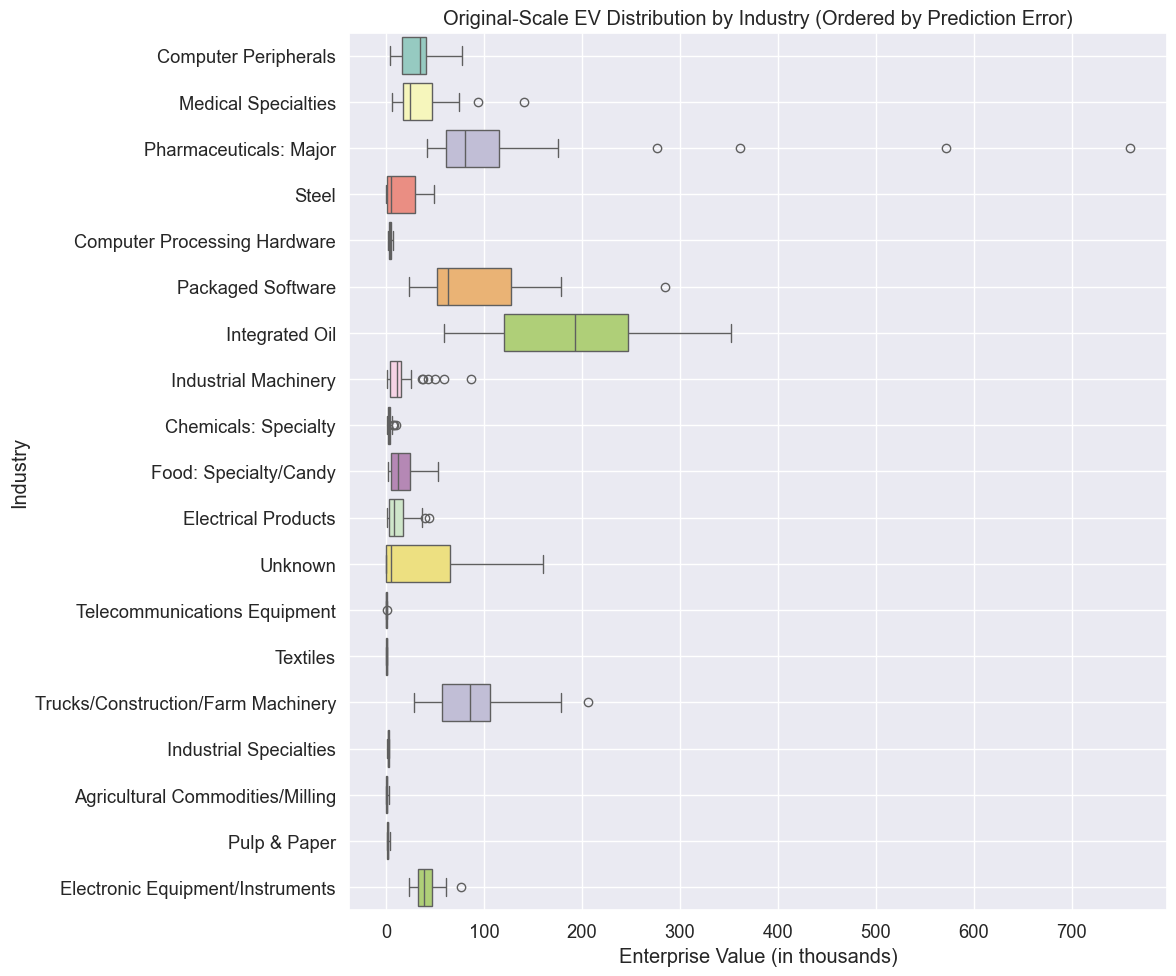


===== OLS Regression Analysis =====


Feature         Coef.      Std.Err.          t         P>|t|  \
0                 const -5.397619e+01  9.003291e+00  -5.995163  3.101423e-09   
1               Country -5.432057e-02  1.615530e-02  -3.362399  8.101959e-04   
2              Industry -3.441740e-02  2.875918e-03 -11.967449  1.979115e-30   
3                  Year  3.097805e-02  4.466883e-03   6.935048  8.504080e-12   
4        Asset Turnover -4.778731e-01  1.088269e-01  -4.391130  1.282555e-05   
5                 Capex  1.198991e-07  3.475159e-08   3.450176  5.902087e-04   
6     Capex as % of Rev  3.531806e-03  6.707008e-03   0.526584  5.986313e-01   
7   Cash and Cash Equiv -1.297707e-08  1.633299e-08  -0.794531  4.271271e-01   
8        Debt to Equity -4.452510e-04  3.048291e-04  -1.460658  1.445105e-01   
9                EBITDA -2.208667e-08  2.798116e-08  -0.789341  4.301518e-01   
10               Equity  5.002491e-06  2.341956e-06   2.136031  3.298641e-02   
11       Free Cash Flow  8.526826e-08  2.973480e-08   2.867625  4.246756e-03   
12         Gross Margin  4.318811e-02  3.059628e-03  14.115481  1.788732e-40   
13           Market Cap  3.194313e-05  3.493016e-06   9.144856  5.055593e-19   
14           Net Income -5.176928e-08  2.157328e-08  -2.399695  1.664141e-02   
15        Profit Margin -2.548150e-02  8.717362e-03  -2.923075  3.565814e-03   
16          Quick Ratio -3.734609e-01  6.794460e-02  -5.496551  5.242682e-08   
17          RD Expenses -6.172940e-07  7.295201e-08  -8.461645  1.288740e-16   
18                  ROA  7.348434e-02  2.623376e-02   2.801136  5.217889e-03   
19                  ROE -4.786558e-03  3.850015e-03  -1.243257  2.141452e-01   
20                 ROIC  1.781955e-02  1.744899e-02   1.021237  3.074575e-01   
21         SGA Expenses  1.498273e-07  3.598353e-08   4.163774  3.477923e-05   
22                Sales  9.767897e-09  3.116035e-09   3.134720  1.784379e-03   
23         Sales Growth -3.760751e-04  1.246543e-03  -0.301694  7.629651e-01   
24         Total Assets -5.019737e-06  2.342108e-06  -2.143256  3.240010e-02   
25           Total Debt  1.165070e-07  1.594130e-08   7.308502  6.672552e-13   
26    Total Liabilities  5.023648e-06  2.343380e-06   2.143762  3.235938e-02   

          [0.025        0.975]  
0  -7.164963e+01 -3.630275e+01  
1  -8.603340e-02 -2.260775e-02  
2  -4.006282e-02 -2.877198e-02  
3   2.220957e-02  3.974654e-02  
4  -6.915002e-01 -2.642461e-01  
5   5.168180e-08  1.881164e-07  
6  -9.634039e-03  1.669765e-02  
7  -4.503870e-08  1.908456e-08  
8  -1.043630e-03  1.531280e-04  
9  -7.701364e-08  3.284029e-08  
10  4.052355e-07  9.599747e-06  
11  2.689890e-08  1.436376e-07  
12  3.718207e-02  4.919416e-02  
13  2.508634e-05  3.879991e-05  
14 -9.411758e-08 -9.420975e-09  
15 -4.259367e-02 -8.369335e-03  
16 -5.068360e-01 -2.400858e-01  
17 -7.604987e-07 -4.740894e-07  
18  2.198751e-02  1.249812e-01  
19 -1.234413e-02  2.771014e-03  
20 -1.643278e-02  5.207189e-02  
21  7.919169e-08  2.204629e-07  
22  3.651126e-09  1.588467e-08  
23 -2.823037e-03  2.070887e-03  
24 -9.617291e-06 -4.221823e-07  
25  8.521428e-08  1.477998e-07  
26  4.235971e-07  9.623699e-06


===== Significant Variables (p < 0.05) =====


Feature         Coef.      Std.Err.          t         P>|t|  \
12       Gross Margin  4.318811e-02  3.059628e-03  14.115481  1.788732e-40   
2            Industry -3.441740e-02  2.875918e-03 -11.967449  1.979115e-30   
13         Market Cap  3.194313e-05  3.493016e-06   9.144856  5.055593e-19   
17        RD Expenses -6.172940e-07  7.295201e-08  -8.461645  1.288740e-16   
25         Total Debt  1.165070e-07  1.594130e-08   7.308502  6.672552e-13   
3                Year  3.097805e-02  4.466883e-03   6.935048  8.504080e-12   
0               const -5.397619e+01  9.003291e+00  -5.995163  3.101423e-09   
16        Quick Ratio -3.734609e-01  6.794460e-02  -5.496551  5.242682e-08   
4      Asset Turnover -4.778731e-01  1.088269e-01  -4.391130  1.282555e-05   
21       SGA Expenses  1.498273e-07  3.598353e-08   4.163774  3.477923e-05   
5               Capex  1.198991e-07  3.475159e-08   3.450176  5.902087e-04   
1             Country -5.432057e-02  1.615530e-02  -3.362399  8.101959e-04   
22              Sales  9.767897e-09  3.116035e-09   3.134720  1.784379e-03   
15      Profit Margin -2.548150e-02  8.717362e-03  -2.923075  3.565814e-03   
11     Free Cash Flow  8.526826e-08  2.973480e-08   2.867625  4.246756e-03   
18                ROA  7.348434e-02  2.623376e-02   2.801136  5.217889e-03   
14         Net Income -5.176928e-08  2.157328e-08  -2.399695  1.664141e-02   
26  Total Liabilities  5.023648e-06  2.343380e-06   2.143762  3.235938e-02   
24       Total Assets -5.019737e-06  2.342108e-06  -2.143256  3.240010e-02   
10             Equity  5.002491e-06  2.341956e-06   2.136031  3.298641e-02   

          [0.025        0.975]  
12  3.718207e-02  4.919416e-02  
2  -4.006282e-02 -2.877198e-02  
13  2.508634e-05  3.879991e-05  
17 -7.604987e-07 -4.740894e-07  
25  8.521428e-08  1.477998e-07  
3   2.220957e-02  3.974654e-02  
0  -7.164963e+01 -3.630275e+01  
16 -5.068360e-01 -2.400858e-01  
4  -6.915002e-01 -2.642461e-01  
21  7.919169e-08  2.204629e-07  
5   5.168180e-08  1.881164e-07  
1  -8.603340e-02 -2.260775e-02  
22  3.651126e-09  1.588467e-08  
15 -4.259367e-02 -8.369335e-03  
11  2.689890e-08  1.436376e-07  
18  2.198751e-02  1.249812e-01  
14 -9.411758e-08 -9.420975e-09  
26  4.235971e-07  9.623699e-06  
24 -9.617291e-06 -4.221823e-07  
10  4.052355e-07  9.599747e-06


===== Variance Inflation Factors (VIF) =====


Feature           VIF  HighVIF
0               Country  2.077809e+01     True
1              Industry  8.317716e+00    False
2                  Year  6.848398e+01     True
3        Asset Turnover  1.634278e+01     True
4                 Capex  2.201423e+01     True
5     Capex as % of Rev  3.675116e+00    False
6   Cash and Cash Equiv  8.612427e+00    False
7        Debt to Equity  3.048631e+00    False
8                EBITDA  5.330730e+01     True
9                Equity  4.180797e+06     True
10       Free Cash Flow  5.171783e+00    False
11         Gross Margin  1.327406e+01     True
12           Market Cap  6.254152e+00    False
13           Net Income  7.733949e+00    False
14        Profit Margin  9.138705e+00    False
15          Quick Ratio  7.865841e+00    False
16          RD Expenses  1.017385e+01     True
17                  ROA  5.321722e+01     True
18                  ROE  9.972291e+00    False
19                 ROIC  6.405338e+01     True
20         SGA Expenses  1.952041e+01     True
21                Sales  2.402287e+01     True
22         Sales Growth  1.264357e+00    False
23         Total Assets  1.535480e+07     True
24           Total Debt  3.107657e+01     True
25    Total Liabilities  3.953999e+06     True


⚠️ Warning: Some features have VIF > 10, indicating possible multicollinearity.


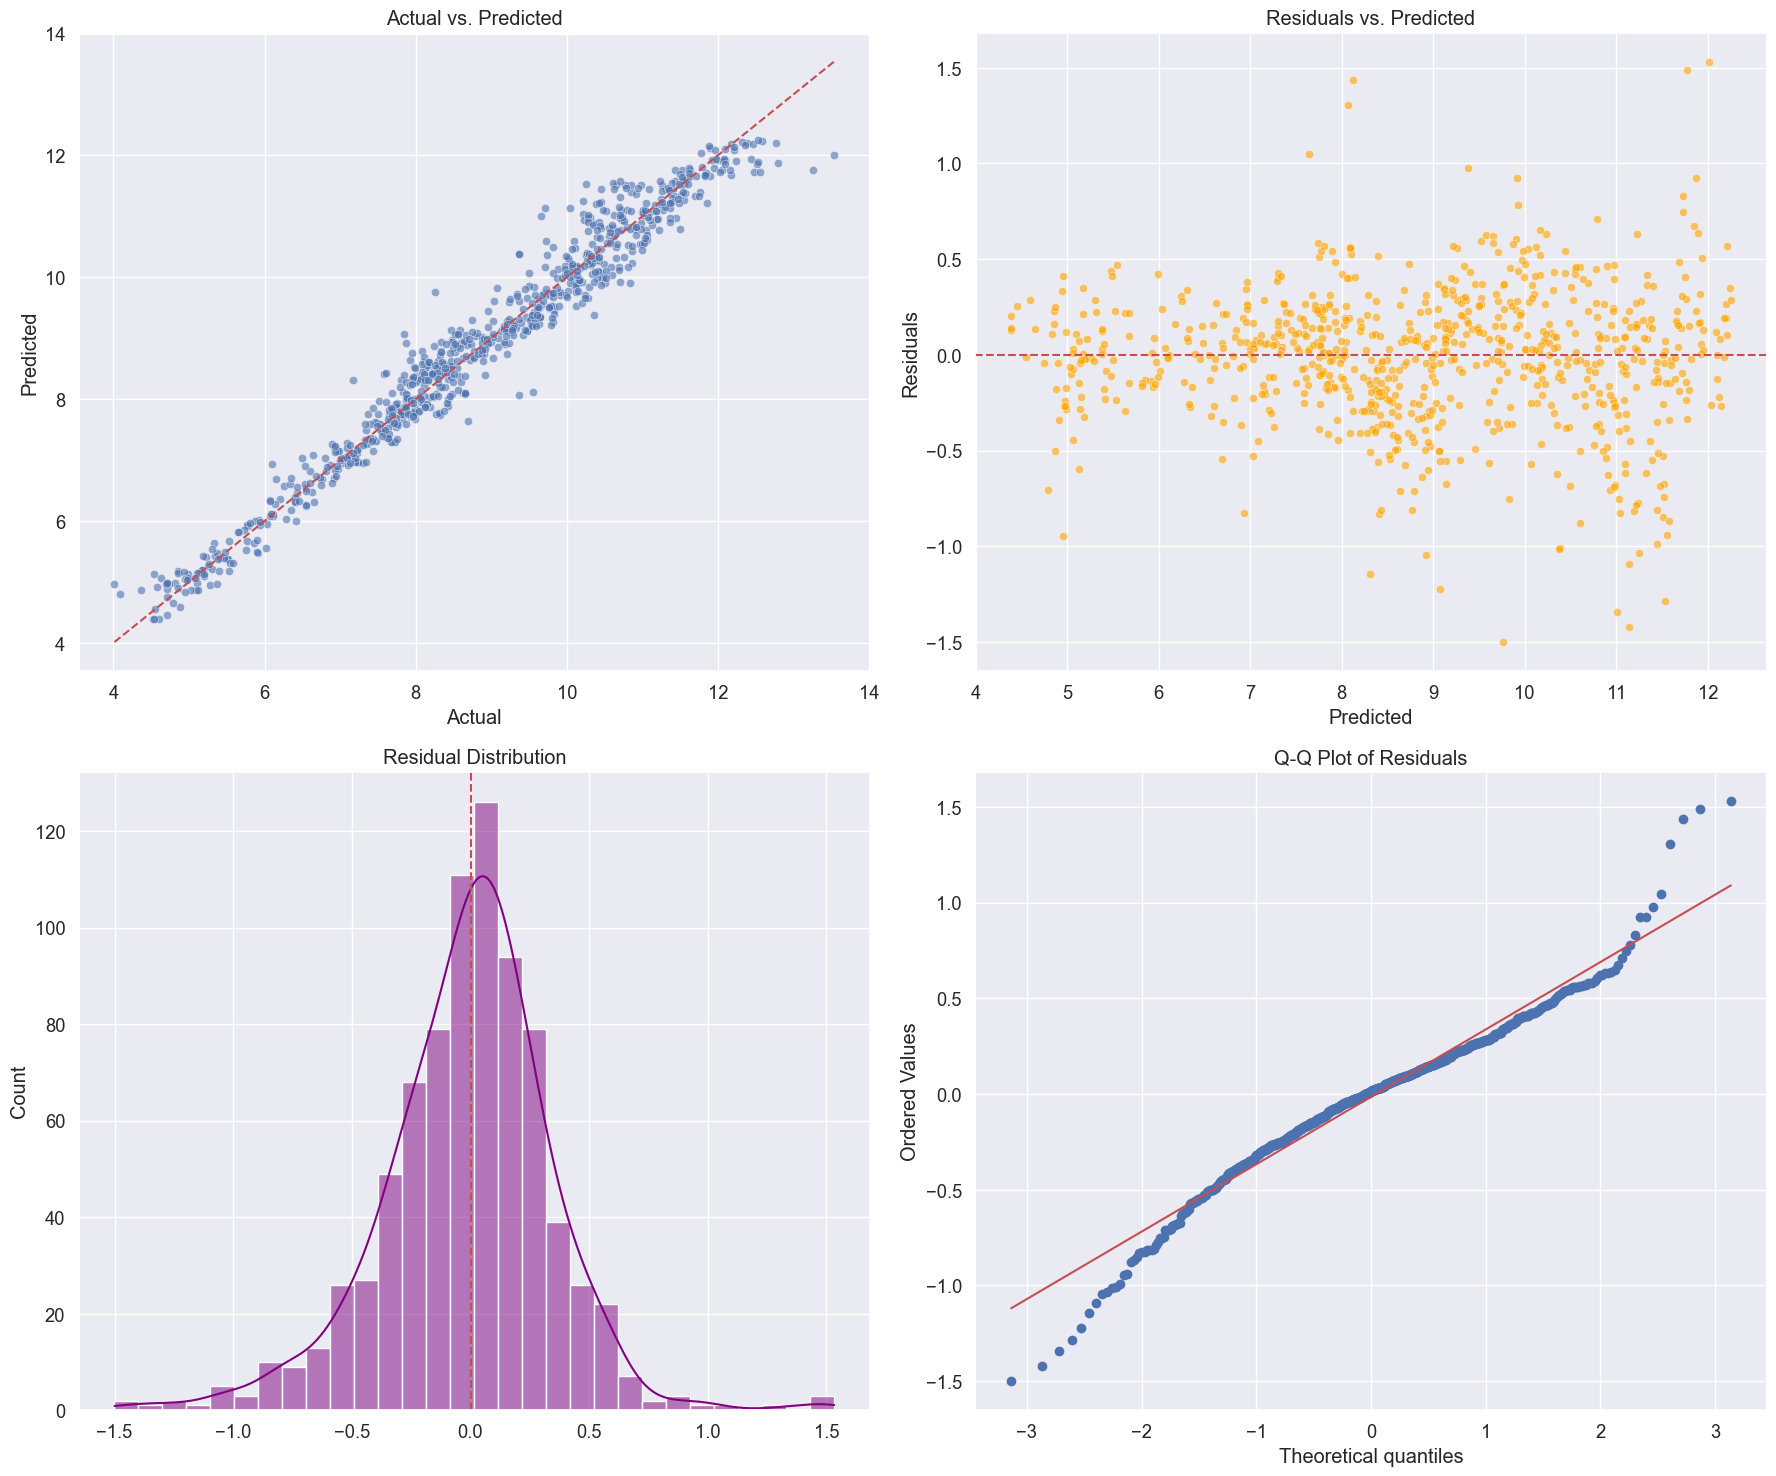

/var/folders/rw/tny5x7_92312zbndrqtmw2dh0000gn/T/ipykernel_44172/821417271.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=vif_data.sort_values("VIF", ascending=False), palette="viridis")


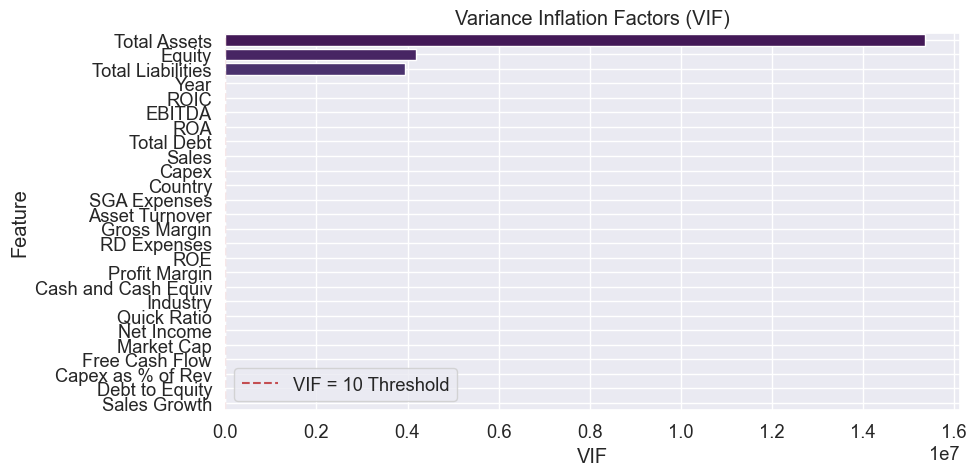

In [24]:
# Compare predictions with actual values on test data
test_predictions = compare_predictions(model, X_val, Y_val, X_val)

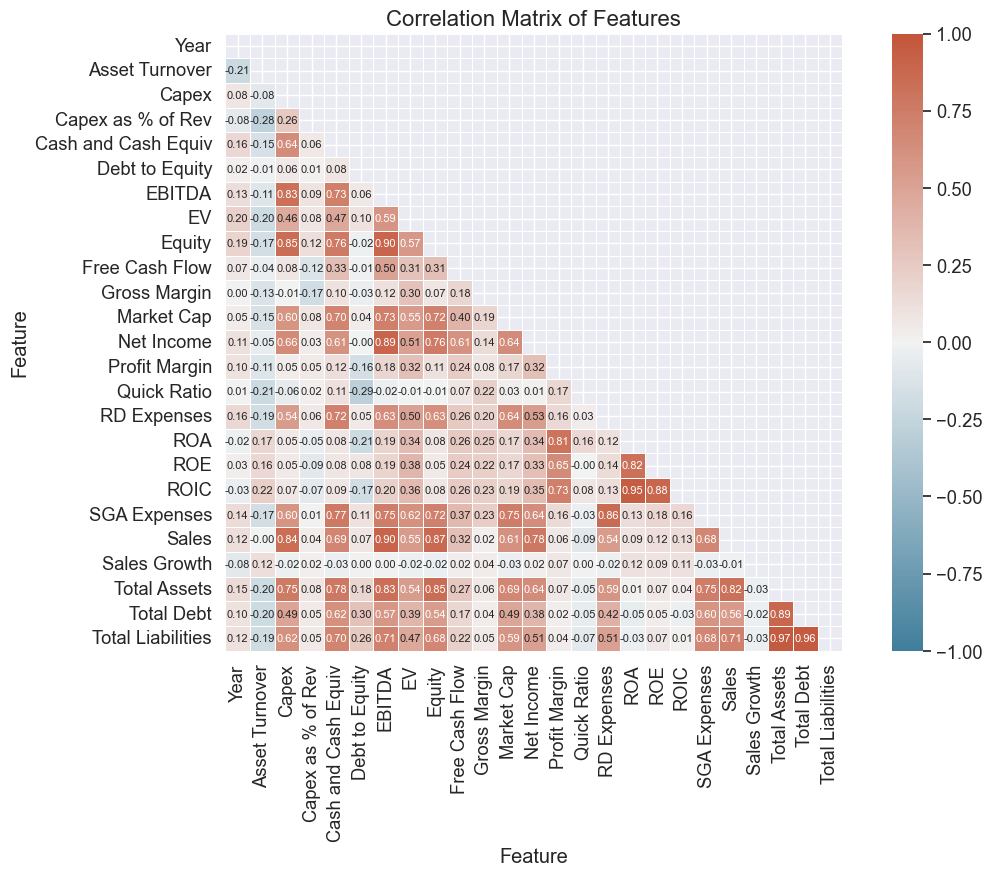

Top 10 Positive Correlations with EV:
Feature
EV                     1.000000
SGA Expenses           0.622160
EBITDA                 0.589730
Equity                 0.566339
Market Cap             0.554709
Sales                  0.550411
Total Assets           0.543741
Net Income             0.508050
RD Expenses            0.504802
Cash and Cash Equiv    0.473332
Total Liabilities      0.473014
Name: EV, dtype: float64

Top 10 Negative Correlations with EV:
Feature
ROA                  0.338513
Profit Margin        0.316758
Free Cash Flow       0.310978
Gross Margin         0.304143
Year                 0.203521
Debt to Equity       0.103443
Capex as % of Rev    0.076627
Quick Ratio         -0.006379
Sales Growth        -0.019663
Asset Turnover      -0.200662
Name: EV, dtype: float64


In [14]:
# Create correlation matrix for all numeric columns in result_df
plt.figure(figsize=(12, 9))

# Select only numeric columns for correlation
numeric_df = result_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 8})

plt.title('Correlation Matrix of Features', fontsize=16)
plt.tight_layout()
plt.show()

# If you want to see the top correlations with a specific target variable (e.g., 'EV' if it exists)
if 'EV' in result_df.columns:
    # Get correlations with EV
    ev_correlations = corr_matrix['EV'].sort_values(ascending=False)
    
    # Display top 10 positive and negative correlations
    print("Top 10 Positive Correlations with EV:")
    print(ev_correlations.head(11))  # 11 because EV itself will be included with correlation 1.0
    
    print("\nTop 10 Negative Correlations with EV:")
    print(ev_correlations.tail(10))

In [ ]:
# Write the result to a new Excel file
output_file = "Final Dataframe to Check.xlsx"
result_df.to_excel(output_file, index=False)

In [ ]:
tesla_q1_2025 = {
    "Country": 10,
    "Industry": 33,
    "Year": 2025,
    "Asset Turnover": 0.0085,
    "Capex": 10179000,  # $1.492 billion
    "Capex as % of Rev": 0.0116,  # 7.72%
    "Cash and Cash Equiv": 37000000,  # $37.0 billion
    "Debt to Equity": 0.1421,
    "EBITDA": 10000000,  # $2.814 billion
    "Equity": 73680000,  # $74.653 billion
    "Free Cash Flow": 5586000,  # $664 million
    "Gross Margin": 0.1786,
    "Market Cap": 1050000000,  # not reported in Q1 filing
    "Net Income": 6062000,  # $409 million
    "Profit Margin": 0.073,  # 2.11%
    "Quick Ratio": 0.016,  # not disclosed
    "RD Expenses": 5313000,  # $1.409 billion
    "ROA": 0.0624,  # 
    "ROE": 0.1052,  # 
    "ROIC": 0.0935,  # 
    "SGA Expenses": 5116000,  # $1.251 billion
    "Sales": 92720000,  # $19.335 billion
    "Sales Growth": -0.0273,  # -9% YoY
    "Total Assets": 122000000,  # $125.111 billion
    "Total Debt": 13600000,  # $7.529 billion
    "Total Liabilities": 48390000  # $48.39 billion
}

tesla_fy2022 = {
    "Country": 10,
    "Industry": 33,
    "Year": 2022,
    "Asset Turnover": 0.989,
    "Capex": 7158000,
    "Capex as % of Rev": 0.0879,
    "Cash and Cash Equiv": 22185000,
    "Debt to Equity": 0.08,
    "EBITDA": 17375000,
    "Equity": 44704000,
    "Free Cash Flow": 7566000,
    "Gross Margin": 0.256,
    "Market Cap": 388980000,
    "Net Income": 12556000,
    "Profit Margin": 0.154,
    "Quick Ratio": 0.83,
    "RD Expenses": 3075000,
    "ROA": 0.1525,
    "ROE": 0.2809,
    "ROIC": 0.2632,
    "SGA Expenses": 3946000,
    "Sales": 81462000,
    "Sales Growth": 0.514,
    "Total Assets": 82338000,
    "Total Debt": 2099000,
    "Total Liabilities": 36440000
}

# Convert to DataFrame with same structure as X_encoded
# Fix: Wrap the dictionary in a list to create a DataFrame with a single row
manual_df = pd.DataFrame([tesla_fy2022])
print(manual_df)

In [ ]:
# Make prediction using the random forest model
manual_prediction = rand_frst_reg.predict(manual_df)

# Transform the prediction from log units back to normal units
# Assuming the prediction was made on log-transformed data
normal_prediction = np.exp(manual_prediction)*10000

print("Prediction for manual datapoint (log units):", manual_prediction[0])
print("Prediction for manual datapoint (normal units), EV in $ thousands is:", normal_prediction[0]/manual_df['EBITDA'][0])
print("Prediction for manual datapoint (normal units), price per share should be:", normal_prediction[0]/3500000)